In [34]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [35]:
def parseData(df):
    """
    处理数据
    """
#     '--'转为'未知方式'
    df['rentType'][df['rentType']=='--'] = '未知方式'
    
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
#     使用众数1994填充
    df['buildYear'] = np.where(df['buildYear'] == '暂无信息', 1994, df['buildYear'])
    df['buildYear'] = df['buildYear'].astype('int')
    
#     处理缺失值
    # 处理pv和uv的空值,缺失值用平均值代替
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
#     df['pv'] = df['pv'].astype('int')
#     df['uv'] = df['uv'].astype('int')
    
    # 去掉部分特征
    df.drop('ID',axis=1, inplace=True)
    df.drop('city',axis=1,inplace=True)
    
    
    return df

In [36]:
def washData(df_train, df_test):
    """
    清洗数据
    """
    df_train = df_train[(df_train['area']<=700) & (df_train['tradeMoney']<=30000)]
#     df_train = df_train[df_train['tradeMoney']<=30000]
    
    return df_train, df_test

In [37]:
def feature(df):
    """
    特征
    """
    # 将houseType转化为‘房间数room’，‘厅数parlor’，‘卫生间数bathroom’
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    room='_roomNum'
    bathroom='_bathroomNum'
    parlor='_parlorNum'
    df.insert(3,room,None)
    df.insert(4, parlor, None)
    df.insert(5, bathroom, None)
    df[room] = df['houseType'].apply(parseRoom, index=0)
    df[parlor] = df['houseType'].apply(parseRoom, index=1)
    df[bathroom] = df['houseType'].apply(parseRoom, index=2)
    df.drop('houseType', axis=1, inplace=True)
    
    # 房间总数
    df['_roomsNum'] = df[room] + df[parlor] + df[bathroom]
    
#     交易月份 eg:2018/10/25
    df['_tradeMonth'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
    df.drop('tradeTime', axis=1, inplace=True)
    
    df['_trafficStationNums'] = df['subwayStationNum'] + df['busStationNum']
    df['_schoolNums'] = df['interSchoolNum'] + df['schoolNum'] + df['privateSchoolNum']
    df['_lifeHouseNums'] = df['gymNum'] + df['parkNum'] + df['bankNum'] + df['shopNum'] + df['mallNum'] + df['superMarketNum']
    
    
    categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']
    return df, categorical_feats

In [38]:
def getData():
    """
    获取数据
    """
    train = pd.read_csv('dataset/train_data.csv')
    test = pd.read_csv('dataset/test_a.csv')
    
    train, test = washData(train, test)
    train = parseData(train)
    test = parseData(test)
   
    train, col = feature(train)
    test, col = feature(test)
    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    return train, test, target, features, categorical_feats

In [39]:
def getInitData():
    """
    获取原始数据
    """
    train = pd.read_csv('dataset/train_data.csv')
    test = pd.read_csv('dataset/test_a.csv')
    return train, test

In [40]:
# 原始数据分析
itrain, itest = getInitData()

In [41]:
itest['tradeTime'].head(1)

0    2018/10/25
Name: tradeTime, dtype: object

In [42]:
# 之后为清洗后数据
train, test, target, features, categorical_feats = getData()

D:\software\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
features

Index(['area', 'rentType', '_roomNum', '_parlorNum', '_bathroomNum',
       'houseFloor', 'totalFloor', 'houseToward', 'houseDecoration',
       'communityName', 'region', 'plate', 'buildYear', 'saleSecHouseNum',
       'subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum',
       'privateSchoolNum', 'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum',
       'shopNum', 'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney',
       'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
       'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
       'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers',
       'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', '_roomsNum',
       '_tradeMonth', '_trafficStationNums', '_schoolNums', '_lifeHouseNums'],
      dtype='object')

# 特征选择 待更新

In [44]:
# SlectKBest:只保留k个最高得分的特征
# SelectPercentile:只保留用户指定前百分之多少的特征
# SelectFpr(假正率)/SelectFdr(错误发现率)/SelectFwe(误差率判断族):对每个特征应用常见的单变量统计检验
# GenericUnivariateSelect:具有可配置策略的单变量特征选择.利用超参数搜索策略,该方法可获得最优的单变量选择策略
# 以上几种特征选择器的输入是评分函数,输出是单变量得分和p-值(SelectKBest和SelectPercentile只返回单变量得分)
from sklearn.feature_selection import SelectKBest
# 回归问题:f_regression,mutual_info_regression 
from sklearn.feature_selection import f_regression

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41271 entries, 0 to 41439
Data columns (total 54 columns):
area                   41271 non-null float64
rentType               41271 non-null category
_roomNum               41271 non-null int64
_parlorNum             41271 non-null int64
_bathroomNum           41271 non-null int64
houseFloor             41271 non-null category
totalFloor             41271 non-null int64
houseToward            41271 non-null category
houseDecoration        41271 non-null category
communityName          41271 non-null category
region                 41271 non-null category
plate                  41271 non-null category
buildYear              41271 non-null int32
saleSecHouseNum        41271 non-null int64
subwayStationNum       41271 non-null int64
busStationNum          41271 non-null int64
interSchoolNum         41271 non-null int64
schoolNum              41271 non-null int64
privateSchoolNum       41271 non-null int64
hospitalNum            41271 non

In [46]:
# 数值特征
print(train.columns)
num_features=list()
for i in features:
    if train[i].dtype in ['int64','float64','int32']:
        num_features.append(i)
num_features

Index(['area', 'rentType', '_roomNum', '_parlorNum', '_bathroomNum',
       'houseFloor', 'totalFloor', 'houseToward', 'houseDecoration',
       'communityName', 'region', 'plate', 'buildYear', 'saleSecHouseNum',
       'subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum',
       'privateSchoolNum', 'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum',
       'shopNum', 'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney',
       'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
       'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
       'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers',
       'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', '_roomsNum',
       '_tradeMonth', '_trafficStationNums', '_schoolNums', '_lifeHouseNums'],
      dtype='object')


['area',
 '_roomNum',
 '_parlorNum',
 '_bathroomNum',
 'totalFloor',
 'buildYear',
 'saleSecHouseNum',
 'subwayStationNum',
 'busStationNum',
 'interSchoolNum',
 'schoolNum',
 'privateSchoolNum',
 'hospitalNum',
 'drugStoreNum',
 'gymNum',
 'bankNum',
 'shopNum',
 'parkNum',
 'mallNum',
 'superMarketNum',
 'totalTradeMoney',
 'totalTradeArea',
 'tradeMeanPrice',
 'tradeSecNum',
 'totalNewTradeMoney',
 'totalNewTradeArea',
 'tradeNewMeanPrice',
 'tradeNewNum',
 'remainNewNum',
 'supplyNewNum',
 'supplyLandNum',
 'supplyLandArea',
 'tradeLandNum',
 'tradeLandArea',
 'landTotalPrice',
 'landMeanPrice',
 'totalWorkers',
 'newWorkers',
 'residentPopulation',
 'pv',
 'uv',
 'lookNum',
 '_roomsNum',
 '_tradeMonth',
 '_trafficStationNums',
 '_schoolNums',
 '_lifeHouseNums']

In [49]:
X, y = train[num_features], target
print(X.shape)
X_new = SelectKBest(f_regression, k=20).fit_transform(X, y)
print(X_new.shape)

(41271, 47)
(41271, 20)


In [51]:
print(len(num_features))
X_new

47


array([[ 68.06,   2.  ,   1.  , ...,  11.  ,  43.  , 137.  ],
       [125.55,   3.  ,   2.  , ...,  12.  , 186.  , 245.  ],
       [132.  ,   3.  ,   2.  , ...,  12.  ,  66.  , 197.  ],
       ...,
       [  9.2 ,   4.  ,   1.  , ...,   2.  , 162.  , 402.  ],
       [ 14.1 ,   4.  ,   1.  , ...,   3.  , 162.  , 402.  ],
       [ 33.5 ,   1.  ,   1.  , ...,  10.  , 120.  , 513.  ]])

In [53]:
X_new

AttributeError: 'numpy.ndarray' object has no attribute 'index'

# 训练

In [15]:
categorical_feats

['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']

In [16]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [23]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0


D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 969.759	valid_1's rmse: 1052.72
[1000]	training's rmse: 856.6	valid_1's rmse: 1013.86
[1500]	training's rmse: 790.616	valid_1's rmse: 1001.26
[2000]	training's rmse: 744.57	valid_1's rmse: 997.872
[2500]	training's rmse: 707.525	valid_1's rmse: 994.862
[3000]	training's rmse: 677.853	valid_1's rmse: 993.911
[3500]	training's rmse: 653.329	valid_1's rmse: 992.89
Early stopping, best iteration is:
[3737]	training's rmse: 642.549	valid_1's rmse: 992.391
fold 1


D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 948.603	valid_1's rmse: 1143.16
[1000]	training's rmse: 837.74	valid_1's rmse: 1116.64
[1500]	training's rmse: 777.377	valid_1's rmse: 1110.68
[2000]	training's rmse: 734.363	valid_1's rmse: 1107.58
[2500]	training's rmse: 699.817	valid_1's rmse: 1105.54
Early stopping, best iteration is:
[2560]	training's rmse: 696.106	valid_1's rmse: 1105.12
fold 2


D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 952.613	valid_1's rmse: 1151.09
[1000]	training's rmse: 842.355	valid_1's rmse: 1110.48
[1500]	training's rmse: 778.703	valid_1's rmse: 1100.73
[2000]	training's rmse: 732.095	valid_1's rmse: 1095.46
[2500]	training's rmse: 696.445	valid_1's rmse: 1094
Early stopping, best iteration is:
[2718]	training's rmse: 683.098	valid_1's rmse: 1093.12
fold 3


D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 958.366	valid_1's rmse: 1091.95
[1000]	training's rmse: 848.918	valid_1's rmse: 1059.66
[1500]	training's rmse: 786.258	valid_1's rmse: 1049.6
[2000]	training's rmse: 741.507	valid_1's rmse: 1045.38
[2500]	training's rmse: 706.67	valid_1's rmse: 1043.1
Early stopping, best iteration is:
[2724]	training's rmse: 693.271	valid_1's rmse: 1042.02
fold 4


D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\software\anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 952.668	valid_1's rmse: 1122.28
[1000]	training's rmse: 843.967	valid_1's rmse: 1095.15
[1500]	training's rmse: 782.068	valid_1's rmse: 1085.57
[2000]	training's rmse: 738.401	valid_1's rmse: 1081.58
[2500]	training's rmse: 703.94	valid_1's rmse: 1079.26
[3000]	training's rmse: 675.652	valid_1's rmse: 1077.84
[3500]	training's rmse: 651.969	valid_1's rmse: 1076.51
Early stopping, best iteration is:
[3395]	training's rmse: 656.688	valid_1's rmse: 1076.28
CV Score: 0.90106 


# 特征贡献值

D:\software\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


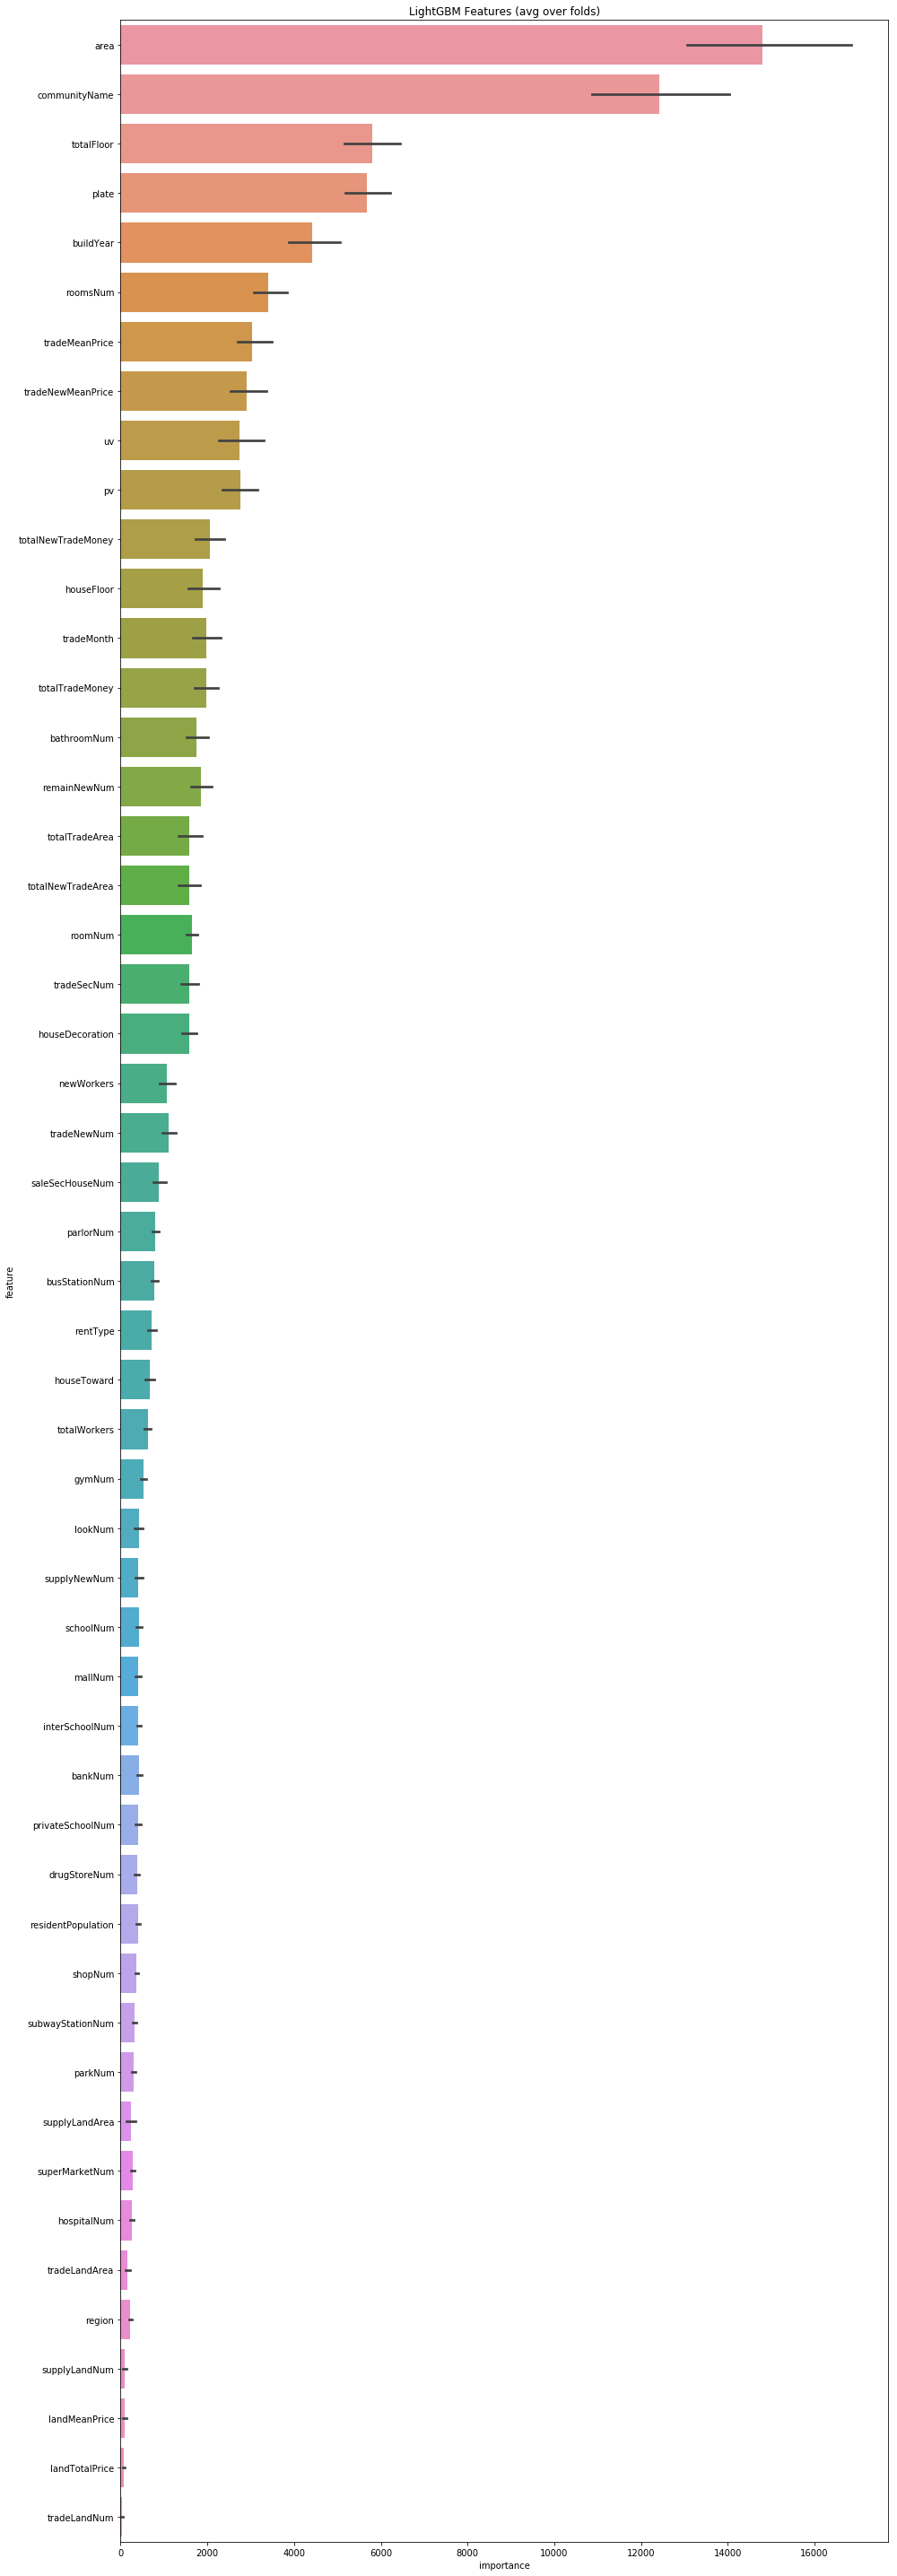

In [25]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# 生成提交数据

In [24]:
pd.DataFrame(predictions_lgb).apply(round).to_csv('submit.csv',na_rep='\n',index=False,encoding='utf8',header=False)